#### Imports


In [118]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
df_clean = pd.read_parquet("../data/cleaned.parquet")
eda_df = df_clean.copy()

In [120]:
# Layer 0: Data sanity
print("Shape:", eda_df.shape)
eda_df.head()


Shape: (17672, 55)


,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,1982,kareem abdul-jabbar,C,34.0,LAL,76,76,35.2,9.9,17.1,...,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695
1,1982,mark aguirre,SF,22.0,DAL,51,20,28.8,7.5,16.1,...,1.9,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341
2,1982,danny ainge,SG,22.0,BOS,53,1,10.6,1.5,4.2,...,0.5,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768
3,1982,tiny archibald,PG,33.0,BOS,68,51,31.9,4.5,9.6,...,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768
4,1982,dennis awtrey,C,33.0,POR,10,3,12.1,0.5,1.5,...,0.0,-0.013,-4.8,-0.3,-5.1,-0.1,0.000,0.60,0.39,0.512


In [121]:
eda_df.dtypes

season                int64
player               object
pos                  object
age                 float64
team_id              object
g                     int64
gs                    int64
mp_per_g            float64
fg_per_g            float64
fga_per_g           float64
fg_pct              float64
fg3_per_g           float64
fg3a_per_g          float64
fg3_pct             float64
fg2_per_g           float64
fg2a_per_g          float64
fg2_pct             float64
efg_pct             float64
ft_per_g            float64
fta_per_g           float64
ft_pct              float64
orb_per_g           float64
drb_per_g           float64
trb_per_g           float64
ast_per_g           float64
stl_per_g           float64
blk_per_g           float64
tov_per_g           float64
pf_per_g            float64
pts_per_g           float64
mp                    int64
per                 float64
ts_pct              float64
fg3a_per_fga_pct    float64
fta_per_fga_pct     float64
orb_pct             

In [122]:
TARGET = "award_share"

# Identifier columns
id_cols = ["season", "player", "team_id", "pos"]

# Soft leakage / team context columns
context_cols = ["mov", "mov_adj", "win_loss_pct"]

# All numeric feature columns except target 
numeric_cols = eda_df.select_dtypes("number").columns.tolist()
feature_num_cols_all = [col for col in numeric_cols if col != TARGET] 

# Model-legal numeric features (exclude team context columns)   
num_cols_no_team_context = [col for col in feature_num_cols_all if col not in id_cols + context_cols]

print("Numeric features (all, excl target):", len(feature_num_cols_all))
print("Numeric features (excl team context):", len(num_cols_no_team_context))

Numeric features (all, excl target): 51
Numeric features (excl team context): 47


#### Layer 1: Target understanding (award_share)

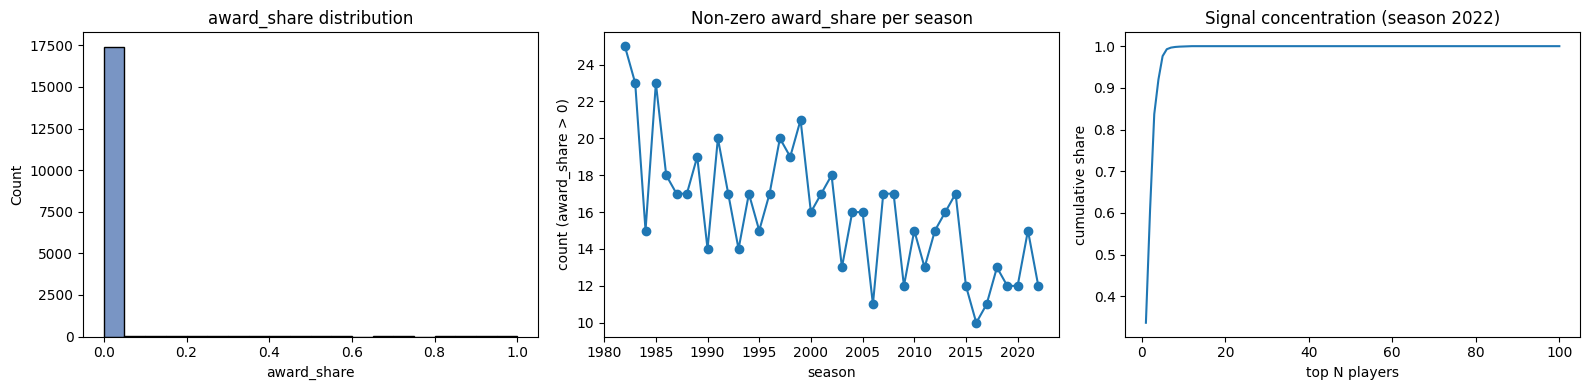

Layer 1 takeaway: Award share is sparse, season-based, and concentrated in a few players.
Modeling impact: Avoid classification due to continuous nature of target; prefer ranking or skew-aware regression; use season-based splits.


In [123]:

target = "award_share"
df = eda_df.copy()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1) Histogram of award_share
sns.histplot(df[target], bins=20, ax=axes[0], color="#4C72B0")
axes[0].set_title("award_share distribution")
axes[0].set_xlabel("award_share")

# 2) Non-zero counts per season (line plot)
non_zero = df[df[target] > 0].groupby("season")[target].size()
axes[1].plot(non_zero.index, non_zero.values, marker="o")
axes[1].set_title("Non-zero award_share per season")
axes[1].set_xlabel("season")
axes[1].set_ylabel("count (award_share > 0)")

# 3) Signal concentration (cumulative share within each season)
# Sort players by award_share within the 2022 season, then compute cumulative fraction of award_share

# Select season
season = df["season"].max()
season_df = df[df["season"] == season].sort_values(target, ascending=False)
cum_share = season_df[target].cumsum() / season_df[target].sum()

top_n = 100
x = range(1, min(top_n, len(cum_share)) + 1)
y = cum_share.values[:top_n]

axes[2].plot(x, y)
axes[2].set_title(f"Signal concentration (season {season})")
axes[2].set_xlabel("top N players")
axes[2].set_ylabel("cumulative share")

plt.tight_layout()
plt.show()

print("Layer 1 takeaway: Award share is sparse, season-based, and concentrated in a few players.")
print("Modeling impact: Avoid classification due to continuous nature of target; prefer ranking or skew-aware regression; use season-based splits.")

#### Layer 2: Feature To Target

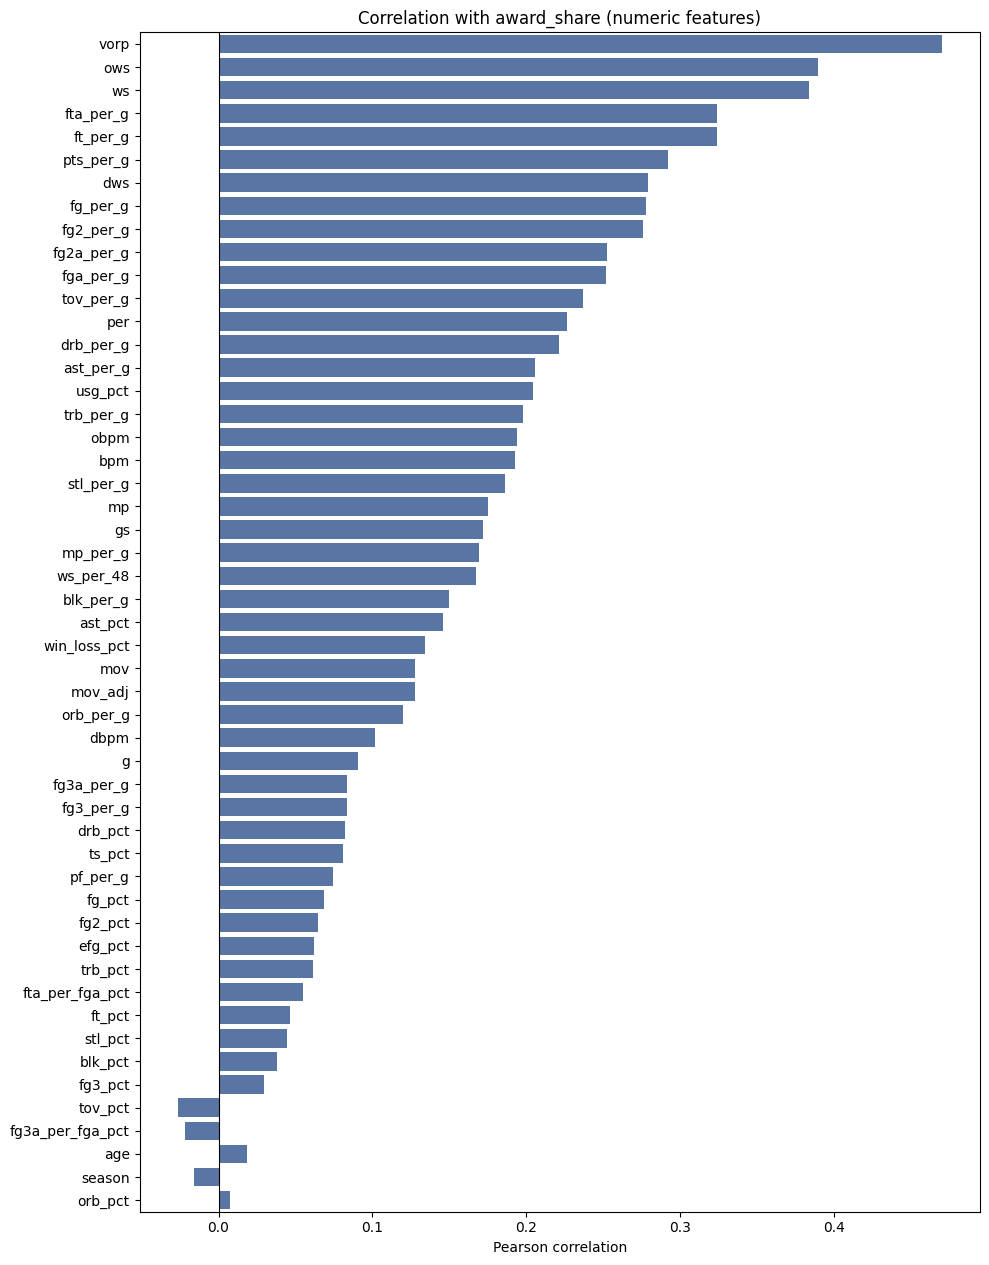

In [124]:
# Ensure numeric-only features (keeps soft leakage and award_share)
numeric_df = df[feature_num_cols_all + [target]]

# Guard: target must be numeric
if target not in numeric_df.columns:
    raise ValueError(f"{target} must be numeric and present in the dataset.")

# Compute correlations vs target
corr = numeric_df.corr(numeric_only=True)[target].drop(target, errors="ignore")

# Sort by absolute value to see dominant signals
corr_sorted = corr.reindex(corr.abs().sort_values(ascending=False).index)

# Plot
plt.figure(figsize=(10, max(6, 0.25 * len(corr_sorted))))
sns.barplot(x=corr_sorted.values, y=corr_sorted.index, color="#4C72B0")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Correlation with award_share (numeric features)")
plt.xlabel("Pearson correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### Layer 3: Feature To Feature

In [125]:
# numeric features only, exclude target
num_df = df[feature_num_cols_all]

corr = num_df.corr()

# Table: near-identity pairs 

pairs = (
    corr.abs()
        .stack()
        .sort_values(ascending=False)
        .reset_index()
)
pairs.columns = ["feature_1", "feature_2", "abs_corr"]
pairs = pairs[pairs["feature_1"] < pairs["feature_2"]]

pairs.head(25)

,feature_1,feature_2,abs_corr
52,mov,mov_adj,0.996925
53,fg_per_g,pts_per_g,0.989802
55,fg2_per_g,fg2a_per_g,0.986455
58,fg3_per_g,fg3a_per_g,0.984524
60,ft_per_g,fta_per_g,0.982810
62,fga_per_g,pts_per_g,0.982150
64,fg_per_g,fga_per_g,0.982003
65,drb_per_g,trb_per_g,0.977807
68,mov,win_loss_pct,0.968181
70,mov_adj,win_loss_pct,0.965293


In [126]:
df["award_share"].gt(0).groupby(df["season"]).sum().describe()

count    41.000000
mean     16.024390
std       3.453171
min      10.000000
25%      13.000000
50%      16.000000
75%      17.000000
max      25.000000
Name: award_share, dtype: float64